# TP3 : Compression Shannon-Huffman

## A. The goal of this part is to implement the Huffman coding and how it can be enhanced to reach the optimal bound.

In [2]:
from __future__ import division
import numpy as np
import scipy as sp
import pylab as pl
import scipy.signal as sg
import matplotlib.pyplot as plt

### The definition of the entropy: Given a probability vector on a finite space $\Omega = \{\omega_1,\ldots,\omega_n\}$ denoted by $p = (p_1,\ldots,p_n)$. The entropy is the quantity defined by $H(p) = -\sum_{i = 1}^n p_i \log(p_i)$. It's a concave function which is positive since $p_i \in [0,1]$ and thus $\log(p_i) \leq 0$.

In [3]:
def ShannonEntropy(p):
    return -np.sum(p*np.log2(np.maximum(p,1e-15)))

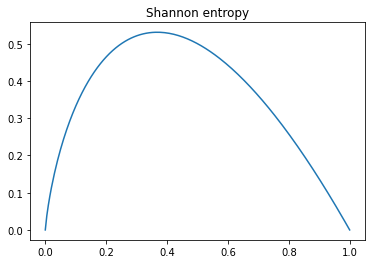

In [4]:
n = 200
x = np.linspace(1e-10,1,n)
plt.title("Shannon entropy")
plt.plot(x,-x*np.log2(x))

### In what follows, we consider that the $\omega_i$ are letters of some alphabet which have a frequency of appearance of $p_i$.

In [5]:
## Generate a random text according to the frequencies.
n = 512; p = 0.3
x = (np.random.rand(n) > p) + 1
h = [np.sum(x == 1), np.sum(x == 2)]
h = h/np.sum(h)
print(h)
print("Empirical p = %.2f" %h[0])

[0.32617188 0.67382812]
Empirical p = 0.33


In [6]:
e = ShannonEntropy(h)
print("Entropy = %.2f" %e)

Entropy = 0.91


In [7]:
### Definition of the probability h
h = [.1, .15, .4, .15, .2]
print(ShannonEntropy(h))

2.1464393446710153


### We use a python library to represent a binary tree. We assume that the tree is coded in the following way, here is an example, $(a,((b,c),(d,e))$.

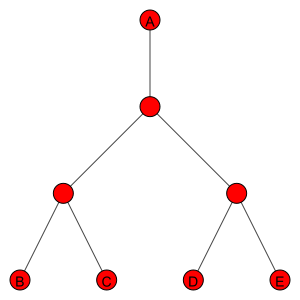

In [8]:
import igraph as ig # also needs 'pip install pycairo'
# https://igraph.org/python/doc/tutorial/tutorial.html#layouts-and-plotting

g = ig.Graph()
g.add_vertices(8)
g.vs["name"] = ["A", " ", " ", " ", "B", "D", "E", "C"]
g.add_edges([(0,1), (1,2), (1, 3), (3, 5), (3, 6), (2, 7), (2, 4)])

# Display the graph
visual_style = {}
visual_style["bbox"] = (300, 300)
visual_style["vertex_label"] = g.vs["name"]
ig.plot(g, layout = g.layout_reingold_tilford(root=[0]), **visual_style)


### Q1. Write a function that generates the Huffman tree with the probability $h$ as input. Plot the tree with the function above. 

In [24]:
## Create the tree as a list.
# https://www.math.upenn.edu/~deturck/m170/wk8/lecture/huffman/huffman.html
# https://bhrigu.me/blog/2017/01/17/huffman-coding-python-implementation/

class NodeTree(object):
    def __init__(self, name, proba, left=None, right=None):
        self.name = name
        self.proba = proba
        self.left = left
        self.right = right

# h a vector of proba
def CreateTree(h):
    nodes = [NodeTree(chr(65 + idx), proba) for idx, proba in enumerate(h)]
    nodes = sorted(nodes, key=lambda node: node.proba, reverse=True)
    
    while (len(nodes) > 1):
        left = nodes.pop()
        right = nodes.pop()
        node = NodeTree('', left.proba + right.proba, left, right)
        nodes.append(node)
        nodes = sorted(nodes, key=lambda node: node.proba, reverse=True)
        
    return nodes[0]

# root a NodeTree root node
def BuildIgGraph(root):
    g = ig.Graph()
    queue = [root]
    parentId = g.add_vertex((root.name, root.proba)).index

    while len(queue) > 0:
        node = queue.pop()
        if node.left:
            queue.append(node.left)
            id = g.add_vertex((node.left.name, node.left.proba)).index
            g.add_edge(parentId, id)
        if node.right:
            queue.append(node.right)
            id = g.add_vertex((node.right.name, node.right.proba)).index
            g.add_edge(parentId, id)
    
        parentId = id

    return g

def print2DUtil(root, space = 0): 
    if (root == None): 
        return

    space += 10
    print2DUtil(root.right, space)  
  
    # Print current node after space
    print()  
    for i in range(10, space): 
        print(end = " ")  
    print(root.name + " (" + str(root.proba) + ")")  
  
    # Process left child  
    print2DUtil(root.left, space)  
    
root = CreateTree(h)
#g = BuildIgGraph(root) # FIXME
#ig.plot(g, layout = g.layout_reingold_tilford(root=0), vertex_label_dist = -1, vertex_label=g.vs["name"], bbox = (500, 300))

print2DUtil(root)


                              E (0.2)

                     (0.35)

                              B (0.15)

           (0.6)

                              D (0.15)

                     (0.25)

                              A (0.1)

 (1.0)

          C (0.4)


### Q2. Write the function HuffmanGencode which computes the Huffman code of an element in $0,1,2,3,4$  and print it.

In [139]:
def getPathFromX(root, path, x): 
    if (not root): 
        return False

    # if it is the required node  
    # return true  
    if (root.name == x):      
        return True
      
    # else check whether the required node  
    # lies in the left subtree or right  
    # subtree of the current node  
    if getPathFromX(root.left, path, x):
        path.append(0)
        return True
    if getPathFromX(root.right, path, x):
        path.append(1)
        return True
      
    # required node does not lie either in  
    # the left or right subtree of the current  
    # node. Thus, remove current node's value   
    # from 'arr'and then return false
    if (len(path) > 1):
        path.pop(-1) 
    return False


def getHuffmanKeysUntilLetter(root,letter):
    keys = [chr(65 + idx) for idx in range(letter)]
    codes = {}
    for i, key in enumerate(keys):
        path = []
        getPathFromX(root, path, key)
        pathChain = ''
        for d in path:
            pathChain += str(d)
        codes.update({keys[i]:pathChain})
        
    return codes

# vector to store the path  
keys = getHuffmanKeysUntilLetter(root,5)
print(keys)

{'A': '001', 'B': '011', 'C': '0', 'D': '101', 'E': '111'}


### Q3. Write a function that generates a random sequence of numbers between $0$ and $4$ according to the probability $h$.

In [54]:
from numpy.random import random_sample

def weighted_values(values, probabilities, size):
    x = np.add.accumulate(probabilities)
    return values[np.digitize(random_sample(size), x)]

def RandGen(p, number):
    sq =  np.array([0,1,2,3,4])
    return weighted_values(sq, h, number)

x = RandGen(h, 512)
print(x) 

[2 2 4 3 1 4 4 3 2 4 3 4 2 2 4 3 1 4 2 0 2 2 2 2 3 4 4 4 4 2 4 2 3 3 4 3 1
 0 2 3 3 2 2 4 0 2 2 1 4 3 2 4 2 3 3 1 2 2 3 2 1 2 4 2 4 2 3 4 2 4 1 3 3 4
 0 3 2 2 4 4 4 4 4 2 2 1 2 1 4 4 4 2 2 2 2 0 0 1 2 2 4 1 3 3 1 2 2 4 4 4 2
 1 2 0 2 2 3 1 4 1 2 2 4 0 3 2 2 2 1 2 2 2 4 1 2 2 3 3 2 2 2 3 3 2 3 0 4 0
 1 4 4 3 2 4 2 4 1 3 4 0 2 0 4 4 2 3 1 4 0 2 4 2 4 2 3 1 2 2 2 4 2 0 2 2 2
 3 2 3 2 3 3 1 3 2 1 4 2 2 1 1 4 2 4 3 2 4 4 2 4 2 2 3 3 1 2 4 2 3 2 4 2 2
 1 2 2 2 3 2 4 2 1 4 1 4 1 2 2 2 2 0 2 2 4 4 2 1 1 2 1 4 1 3 2 3 3 2 3 1 1
 2 2 2 2 0 2 3 4 2 3 1 2 4 1 4 0 4 2 2 3 2 2 1 2 0 2 0 3 2 2 4 2 2 3 1 1 4
 4 2 2 1 2 4 0 2 4 0 2 3 0 2 3 4 2 2 1 2 2 1 0 1 2 4 4 1 1 2 3 4 2 3 0 4 3
 2 0 3 2 4 4 2 0 2 2 4 2 4 2 3 4 2 4 4 1 3 2 3 2 4 2 3 2 2 2 0 3 2 1 2 2 0
 2 0 1 0 2 3 2 2 2 1 2 4 2 2 3 2 3 1 0 2 2 4 2 2 4 2 3 2 1 4 4 2 1 4 1 1 1
 2 2 1 2 4 0 2 3 3 1 4 2 3 2 2 2 2 4 2 3 4 4 3 0 2 2 4 2 0 3 2 4 2 2 1 1 2
 3 2 0 2 0 0 2 0 3 1 0 2 4 4 0 2 2 3 4 2 2 2 4 2 1 4 2 4 3 2 2 3 1 0 1 3 1
 2 1 3 2 4 2 2 2 4 4 3 4 

### Q4. Write a function which maps a random sequence as above into its Huffman code and test it.

In [55]:
# FIXME
def CodeHuffman(x, codes):
    result = ""
    for elt in x:
        print(codes[elt])
        result += str(codes[elt])
    return result

code = CodeHuffman(x, codes)
print(code)

1
1


IndexError: list index out of range

### Q5. Compare with the Shannon bound.

### Q6. Write below a function that decodes the Huffman code and test it on a random sequence. Check that it is the inverse of the coding map.

In [ ]:
def DecodeHuffman(code,T):
    result = []
    return np.asarray(result)

### Block Huffman coding to reach better performances. 
### We consider a probability as below on an alphabet of two letters $a,b$.

### Q7: Compute the entropy associated with this probability and generalize for an alphabet described by blocks of $k$ letters.

In [ ]:
t = .12
h = [t, 1-t]
n = 20000
x = (np.random.rand(n) > t) + 1

### Q7bis. Compare the length of the Huffman code and the Shannon bound. How to explain the difference ? In order to improve the result, we use Huffman coding on blocks of length $k$. 

### Q8. Write a code that takes as input a sequence of length $k$ of letters and associate a binary code. Then, write a function that takes as inputs a random sequence its code by block of length $k$. We assume that the length is a multiple of $k$.

In [ ]:
def CodeBlocks(x):
    return 0
def GenNewCode(x):
    return 0

### Q9. Write a function that gives the empirical probability of the message encoded by $k$-blocks.

In [ ]:
def EstimateProbabilites(code,taille_blocs):
    return 0

### Q10. Given a random sequence generated from the probability $h$, plot the performance of the Huffman code (length of the code - Shannon bound) in terms of $k$ the block length. Comment.

## B. The goal of this part is to explore implementations of a FIR or an IIR.

### Q1. Implement an ideal low pass filter using Fourier transform in 1D:
### Compute the inverse FFT of a low pass filter and cut it with a window that will be passed in argument. 

### Q2. Implement an IIR filter defined by its numerator which will be set to a  constant $b$ and its denominator which will be set to $1-az^{-1}$. 

#### What can you say about the range of the parameter $a$ in order to obtain a stable filter. 
#### Experimentally, determine the ranges of $a$ to get respectively a low-pass filter and a high-pass filter. Give a theoretical explanation.

### In the following, we are given an electrocardiogram. We plot it as a function of time and we 

In [ ]:
### load the data which is an electrocardiogram which is sampled at 360Hz
ecg = sp.misc.electrocardiogram()
### Different plots.
fs = 360.0
### Since it is sampled at 360Hz, recall that Hz is the number of cycle per second, then the
### time is obtained as follows:
time = np.arange(ecg.size) / fs
### simple plot.
plt.plot(time, ecg)
plt.xlabel("time in s")
plt.ylabel("ECG in mV")
plt.xlim(9, 10.2)
plt.ylim(-1, 1.5)
plt.show()
print("time min", time[0])
print("time max", time[-1])

In [ ]:
### Use the scipy function to get the power spectrum of the signal.
f, Pxx = sg.welch(ecg, fs=fs, nperseg=2048, scaling="spectrum")
plt.semilogy(f, Pxx)
plt.xlabel("Frequency in Hz")
plt.ylabel("Power spectrum of the ECG in mV**2")
plt.xlim(f[[0, -1]])
plt.show()

### Q3. Estimate the number of heartbeats in the following electrocardiogram and estimate the mean value of the interval between two heartbeats. You can use the method of your choice. A possible method consists in using a band pass filter and then extract the maximum values of the filtered signal.